In [1]:
import hmftpy as hmf
from hmftpy.plaquettes.triangular import plaq12, plaq12z, plaq9p, plaq9d, plaq3, plaq7, plaq19, test_bonds
from hmftpy.operators import mf_ops, inner_hamiltonian, periodic_hamiltonian
from hmftpy import do_hmft
from hmftpy.plot_spins import draw_tri_lattice, draw_cluster, plot_spins
from quspin.basis import spin_basis_1d
from quspin.operators import quantum_operator
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
maxit = 50

In [2]:
def ni_op(plaq, basis):
    A, B, C = plaq['n_nearest_sublattice']
    a_op = quantum_operator({'static': [['x', [[1/len(A), j] for j in A]]]}, basis=basis, check_symm=False, check_herm=False)
    b_op = quantum_operator({'static': [['x', [[-0.5/len(B), j] for j in B]],
                                        ['y', [[0.5*np.sqrt(3)/len(B), j] for j in B]]]}, basis=basis, check_symm=False, check_herm=False)
    c_op = quantum_operator({'static': [['x', [[-0.5/len(C), j] for j in C]],
                                        ['y', [[-0.5*np.sqrt(3)/len(C), j] for j in C]]]}, basis=basis, check_symm=False, check_herm=False)
    return a_op + b_op + c_op

def ms_ops(plaq, basis, d='x'):
    xs = plaq['x_stripes']
    ys = plaq['y_stripes']
    zs = plaq['z_stripes']
    xs_op = quantum_operator({'static': [[d, [[1/len(xs[0]), j] for j in xs[0]] + [[-1/len(xs[1]), j] for j in xs[1]]
                                         ]]}, basis=basis, check_symm=False, check_herm=False)
    ys_op = quantum_operator({'static': [[d, [[1/len(ys[0]), j] for j in ys[0]] + [[-1/len(ys[1]), j] for j in ys[1]]
                                         ]]}, basis=basis, check_symm=False, check_herm=False)
    zs_op = quantum_operator({'static': [[d, [[1/len(zs[0]), j] for j in zs[0]] + [[-1/len(zs[1]), j] for j in zs[1]]
                                         ]]}, basis=basis, check_symm=False, check_herm=False)
    return xs_op, ys_op, zs_op

In [3]:
plaqs_lst = [plaq7, plaq9p, plaq9d, plaq12z, plaq12]
bases_lst = [spin_basis_1d(plaq['L'], pauli=0) for plaq in plaqs_lst]
ops_lst = [hmf.operators.mf_ops(plaq, bases_lst[i]) for i, plaq in enumerate(plaqs_lst)]
steps = 50
names = ['7 site', '9 site fish', '9 site diamond', '12 site zigzag', '12 site triangle']
plaqs = {name: plaqs_lst[i] for i, name in enumerate(names)}
bases = {name: bases_lst[i] for i, name in enumerate(names)}
# ops = {name: ops_lst[i] for i, name in enumerate(names)}
energies = {name: np.zeros(steps) for name in names}

Ms_ops_x = {}
Ms_ops_y = {}
for name in names:
    print(name)
    plaq = plaqs[name]
    basis = bases[name]
    Ms_ops_x[name] = ms_ops(plaqs[name], bases[name], d='x')
    Ms_ops_y[name] = ms_ops(plaqs[name], bases[name], d='y')
Mxs = {name: np.zeros(steps) for name in names}
Mys = {name: np.zeros(steps) for name in names}
Mzs = {name: np.zeros(steps) for name in names}

Ni_ops = {name: ni_op(plaqs[name], bases[name]) for name in names}
Ni = {name: np.zeros(steps) for name in names}

degens = {name: np.zeros(steps) for name in names}

J2s = np.linspace(0, 1, steps)



7 site
9 site fish
9 site diamond
12 site zigzag
12 site triangle


In [4]:
for i, J2 in enumerate(tqdm(J2s)):
    interactions = {'nearest': {'xx': 1, 'yy': 1},
                    'n_nearest': {'xx': J2, 'yy': J2}}
    for n in names:
        Hi = inner_hamiltonian(plaqs[n], interactions, bases[n])
        e, v = Hi.eigsh(k=1, which='SA')
        ei = np.argmin(e)
        
        energies[n][i] = np.min(e)
        degens[n][i] = len(e[np.abs(e-np.min(e)) < 10**-10])
        v0 = v[:,ei]
        
        Ni[n][i] = np.real(np.vdot(v0, Ni_ops[n].dot(Ni_ops[n].dot(v0))))
        
        Mxs[n][i] = np.real(np.vdot(v0, Ms_ops_x[n][0].dot(Ms_ops_x[n][0].dot(v0))))
        Mys[n][i] = np.real(np.vdot(v0, Ms_ops_x[n][1].dot(Ms_ops_x[n][1].dot(v0))))
        Mzs[n][i] = np.real(np.vdot(v0, Ms_ops_x[n][2].dot(Ms_ops_x[n][2].dot(v0))))


100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


In [5]:
J2s_lrg = np.linspace(0, 1, 10)
Mxs_19 = np.zeros(10)
Mys_19 = np.zeros(10)
Mzs_19 = np.zeros(10)
Ni_19 = np.zeros(10)
energies_19 = np.zeros(10)
b19 = spin_basis_1d(19, pauli=0)

Ms_ops_x_19 = ms_ops(plaq19, b19, d='x')
Ni_op_19 = ni_op(plaq19, b19)


rn = 1
rnn = np.sqrt(3)
rnnn = 2
for i, J2 in enumerate(tqdm(J2s_lrg)):
    interactions = {'nearest': {'xx': 1, 'yy': 1},
                    'n_nearest': {'xx': J2, 'yy': J2}}
    Hi = inner_hamiltonian(plaq19, interactions, b19)
    print('Hamiltonian formed')
    e, v = Hi.eigsh(k=1, which='SA', tol=10**-10)
    print('Hamiltonian diagonalized')
    energies_19[i] = e[0]
    v0 = v[:,0]

    Ni_19[i] = np.real(np.vdot(v0, Ni_op_19.dot(Ni_op_19.dot(v0))))

    Mxs_19[i] = np.real(np.vdot(v0, Ms_ops_x_19[0].dot(Ms_ops_x_19[0].dot(v0))))
    Mys_19[i] = np.real(np.vdot(v0, Ms_ops_x_19[1].dot(Ms_ops_x_19[1].dot(v0))))
    Mzs_19[i] = np.real(np.vdot(v0, Ms_ops_x_19[2].dot(Ms_ops_x_19[2].dot(v0))))

  0%|          | 0/10 [00:00<?, ?it/s]

Hamiltonian formed


 10%|█         | 1/10 [00:37<05:39, 37.68s/it]

Hamiltonian diagonalized
Hamiltonian formed


 20%|██        | 2/10 [01:46<06:16, 47.07s/it]

Hamiltonian diagonalized
Hamiltonian formed


 30%|███       | 3/10 [02:59<06:22, 54.67s/it]

Hamiltonian diagonalized
Hamiltonian formed
Hamiltonian diagonalized


 40%|████      | 4/10 [04:13<06:04, 60.70s/it]

Hamiltonian formed


 50%|█████     | 5/10 [05:43<05:46, 69.35s/it]

Hamiltonian diagonalized
Hamiltonian formed


 60%|██████    | 6/10 [07:05<04:53, 73.27s/it]

Hamiltonian diagonalized
Hamiltonian formed


 70%|███████   | 7/10 [08:23<03:43, 74.65s/it]

Hamiltonian diagonalized
Hamiltonian formed


 80%|████████  | 8/10 [09:35<02:27, 73.83s/it]

Hamiltonian diagonalized
Hamiltonian formed


 90%|█████████ | 9/10 [10:49<01:13, 73.86s/it]

Hamiltonian diagonalized
Hamiltonian formed


100%|██████████| 10/10 [12:10<00:00, 73.03s/it]

Hamiltonian diagonalized


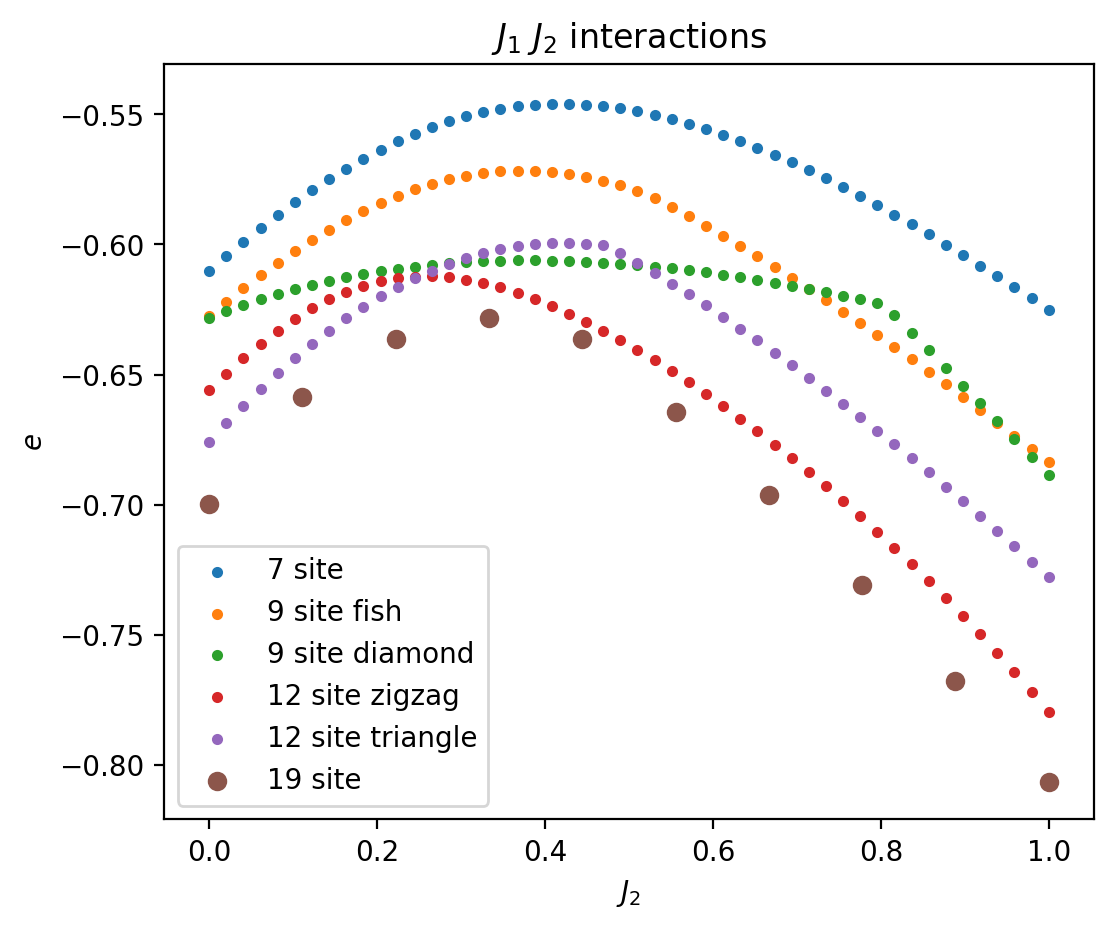

In [6]:
plt.figure(figsize=(6,5), dpi=200)
for n in names:
    plt.scatter(J2s, energies[n]/plaqs[n]['L'], label=n, marker='.')
plt.scatter(J2s_lrg, energies_19/19, label='19 site', marker='o')
plt.legend()
plt.xlabel(r'$J_2$')
plt.ylabel(r'$e$')
plt.title(r'$J_1$ $J_2$ interactions')
plt.savefig('XY_J1J2_energy.png')

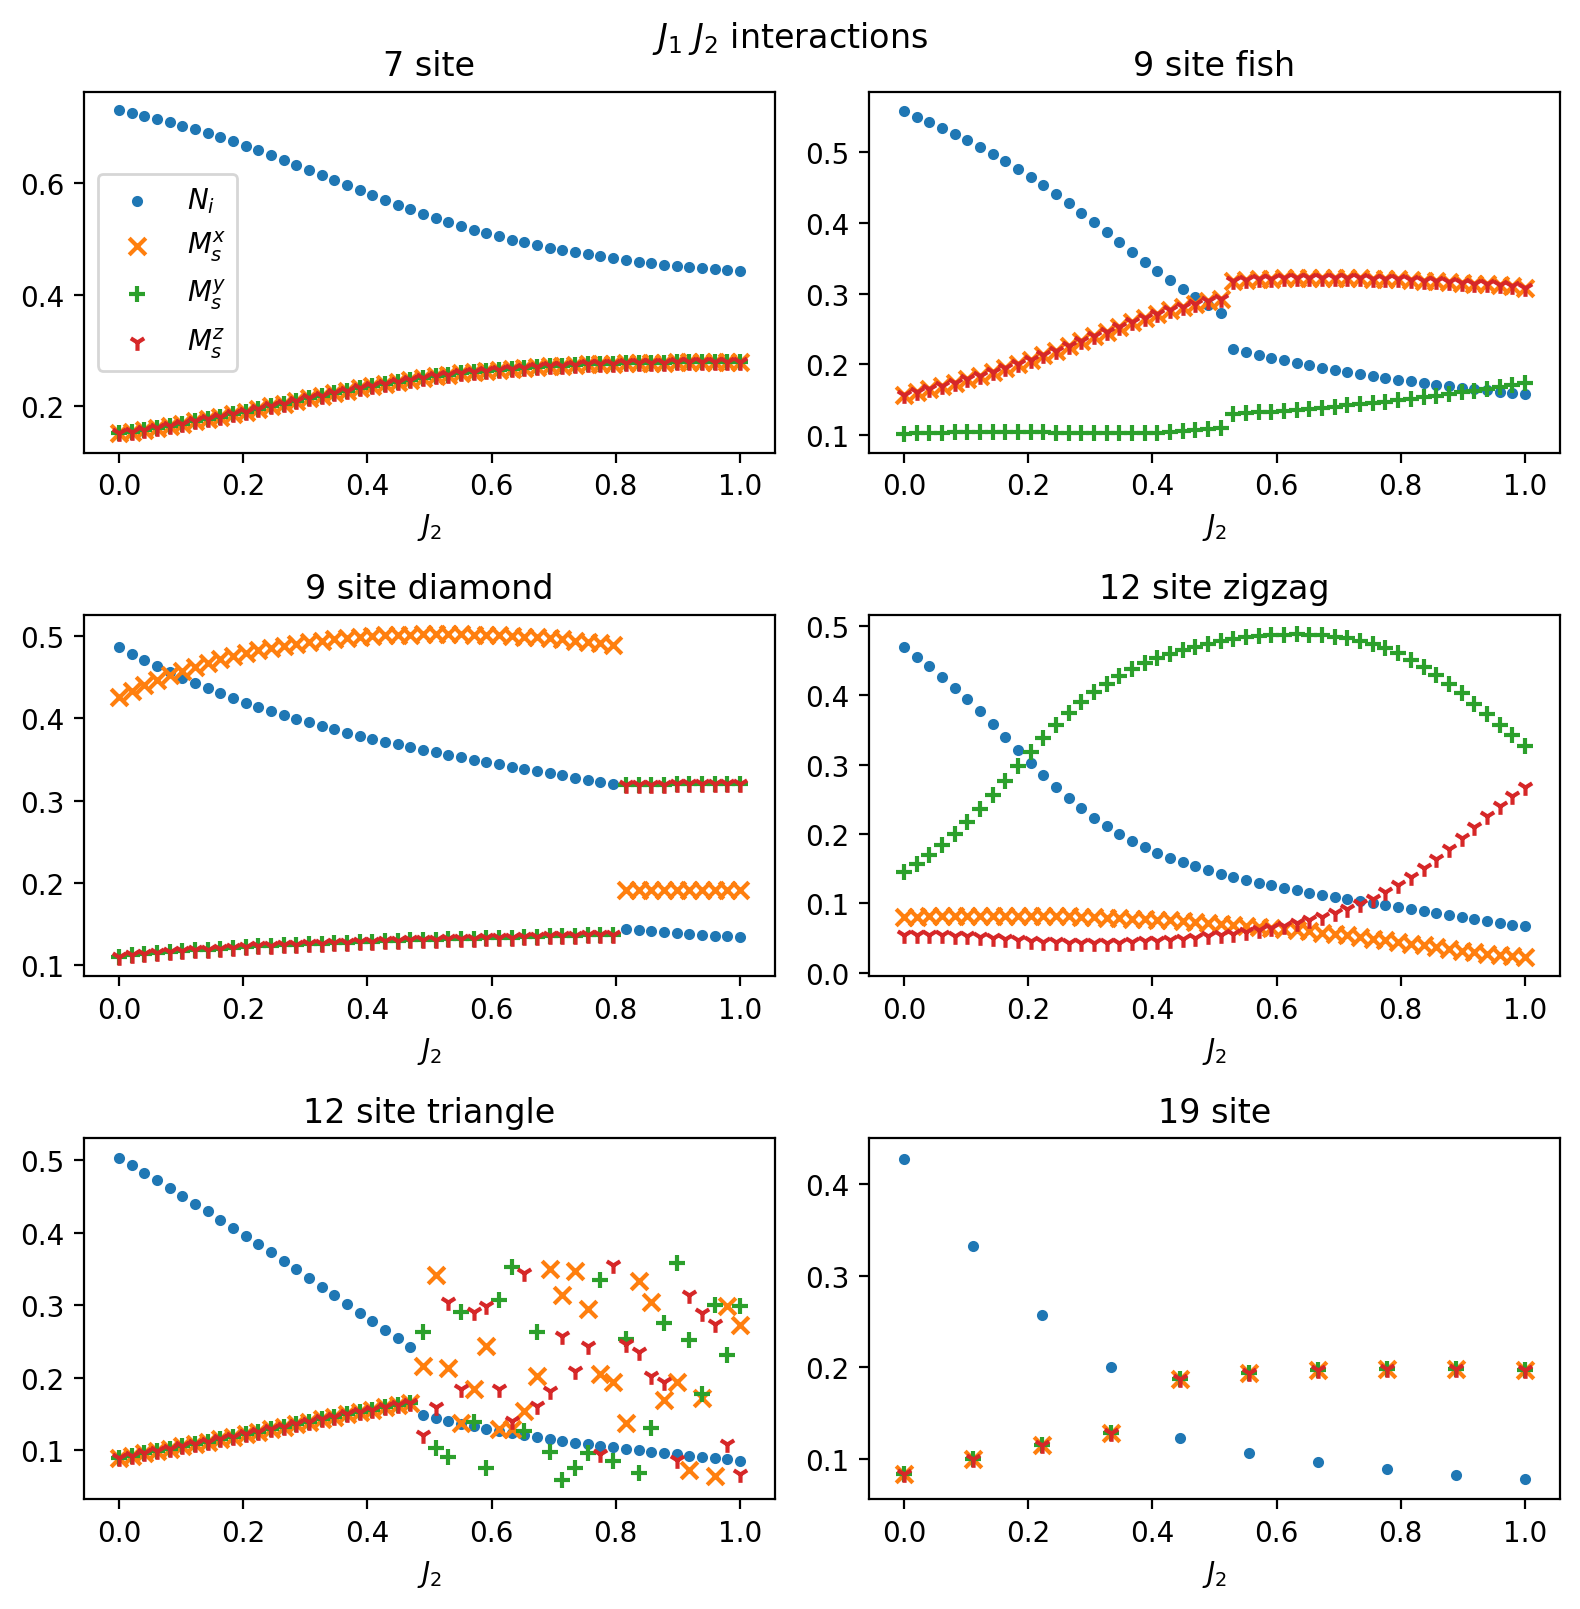

In [7]:
plt.figure(figsize=(8,8), dpi=200)
for i, n in enumerate(names):
    plt.subplot(3,2,i+1)
    plt.scatter(J2s, Ni[n], label=r'$N_i$', marker='.')
    plt.scatter(J2s, Mxs[n], label=r'$M_s^x$', marker='x')
    plt.scatter(J2s, Mys[n], label=r'$M_s^y$', marker='+')
    plt.scatter(J2s, Mzs[n], label=r'$M_s^z$', marker='1')
    # plt.plot(J2s, degens[n], label='Degeneracy')
    plt.title(n)
    plt.xlabel(r'$J_2$')
    if i == 0:
        plt.legend()
    # plt.show()
plt.subplot(3,2,6)
plt.scatter(J2s_lrg, Ni_19, label=r'$N_i$', marker='.')
plt.scatter(J2s_lrg, Mxs_19, label=r'$M_s^x$', marker='x')
plt.scatter(J2s_lrg, Mys_19, label=r'$M_s^y$', marker='+')
plt.scatter(J2s_lrg, Mzs_19, label=r'$M_s^z$', marker='1')
plt.title('19 site')
plt.xlabel(r'$J_2$')
plt.suptitle(r'$J_1$ $J_2$ interactions',y=1)

plt.tight_layout()
plt.savefig('XY_J1J2_order.png')